In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [2]:
og_data = pd.read_csv(r'data/Historical Product Demand.csv')

In [3]:
og_data.info()
og_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [4]:
og_data.dropna(inplace= True)


In [5]:
# The characters () need \ because they are special characters for regex
og_data['Order_Demand']= og_data['Order_Demand'].str.replace('\)','', regex=True)
og_data['Order_Demand']= og_data['Order_Demand'].str.replace('\(','', regex=True)


In [6]:
og_data['Order_Demand'] =  og_data['Order_Demand'].astype(int)
og_data['Date'] = og_data['Date'].astype('datetime64[ns]')

In [7]:
og_data.nunique()
og_data = og_data.set_index('Date')

<Axes: xlabel='Date'>

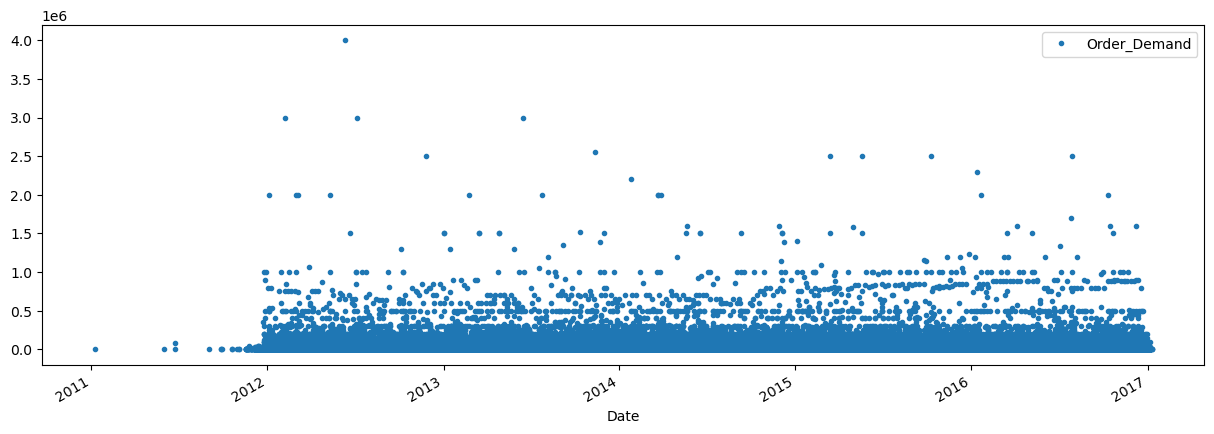

In [8]:
##Plotting
og_data.plot(style= '.', figsize=(15,5))

<Axes: xlabel='Date'>

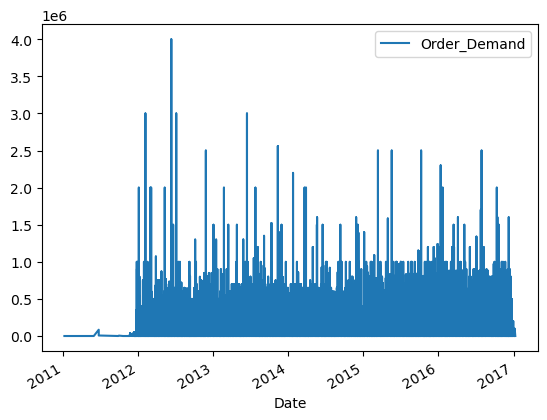

In [9]:
og_data.plot()

## Use standard deviation to identify outliers 3s includes 99,7%

In [10]:
# also some formating here to avoid scientific numbers
og_data.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,Order_Demand
count,1037336.0
mean,4949.4
std,29073.4
min,0.0
25%,20.0
50%,300.0
75%,2000.0
max,4000000.0


## Create upper limit base on standar deviation

In [11]:
upper_limit= og_data.Order_Demand.mean() + 3* og_data.Order_Demand.std()


In [12]:
og_data[(og_data.Order_Demand >= upper_limit)]


,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-18,Product_1159,Whse_J,Category_006,100000
2012-10-01,Product_1159,Whse_J,Category_006,100000
2012-10-18,Product_1159,Whse_J,Category_006,100000
2012-03-08,Product_1157,Whse_J,Category_006,150000
2012-03-08,Product_1157,Whse_J,Category_006,150000
...,...,...,...,...
2016-12-02,Product_1149,Whse_J,Category_006,100000
2016-12-09,Product_1149,Whse_J,Category_006,100000
2016-03-09,Product_1149,Whse_J,Category_006,100000


## Group dataset by order and date

In [13]:
group_df= og_data.groupby('Date').agg(sum)

C:\Users\John\AppData\Local\Temp\ipykernel_24008\3612321277.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  group_df= og_data.groupby('Date').agg(sum)


In [14]:
group_df

,Order_Demand
Date,
2011-01-08,2
2011-05-31,108
2011-06-24,92000
2011-09-02,1250
2011-09-27,28
...,...
2017-01-03,2400
2017-01-04,29250
2017-01-05,83929


In [15]:
#Set frequency as date
group_df = group_df.asfreq('d')
group_df.index


DatetimeIndex(['2011-01-08', '2011-01-09', '2011-01-10', '2011-01-11',
               '2011-01-12', '2011-01-13', '2011-01-14', '2011-01-15',
               '2011-01-16', '2011-01-17',
               ...
               '2016-12-31', '2017-01-01', '2017-01-02', '2017-01-03',
               '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07',
               '2017-01-08', '2017-01-09'],
              dtype='datetime64[ns]', name='Date', length=2194, freq='D')

## How to handles missing dates?

In [16]:
group_df.info()
group_df.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194 entries, 2011-01-08 to 2017-01-09
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Demand  1729 non-null   float64
dtypes: float64(1)
memory usage: 34.3 KB


,Order_Demand
Date,
2011-01-08,2.0
2011-01-09,NaN
2011-01-10,NaN
2011-01-11,NaN
2011-01-12,NaN


# 1 way Exponential (Weighted) Moving Average:

In [17]:
group_df['Order_Demand'] = group_df['Order_Demand'].ewm(halflife=4).mean()

In [18]:
group_df.info()
group_df.head(50)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194 entries, 2011-01-08 to 2017-01-09
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Demand  2194 non-null   float64
dtypes: float64(1)
memory usage: 34.3 KB


,Order_Demand
Date,
2011-01-08,2.0
2011-01-09,2.0
2011-01-10,2.0
2011-01-11,2.0
2011-01-12,2.0
2011-01-13,2.0
2011-01-14,2.0
2011-01-15,2.0
2011-01-16,2.0


## Check if time-series is stationary

In [19]:
test_result= adfuller(group_df['Order_Demand'])

I filtered the data because I assume that early and late values are wrong

<Axes: xlabel='Date'>

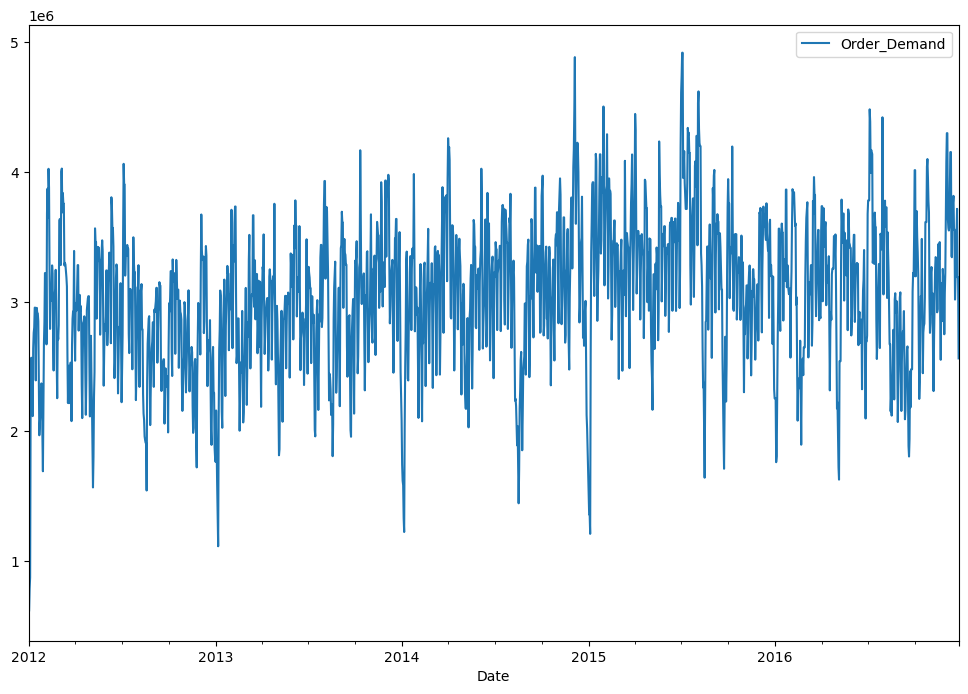

In [20]:
filterr_df= group_df.loc[pd.IndexSlice['2012-01-01':'2016-12-25'], :]
filterr_df.plot(figsize=(12, 8))

In [ ]:
test_result= adfuller(filterr_df['Order_Demand'])

In [ ]:
dfoutput = pd.Series(
test_result[0:4],
index=[
"Test Statistic",
"p-value",
"#Lags Used",
"Number of Observations Used",
],)

In [ ]:
for key, value in test_result[4].items():
    dfoutput["Critical Value (%s)" % key] = value
print(dfoutput)

# Interpret the results
if dfoutput['p-value'] < 0.05:
    print("The time series is likely stationary (reject the null hypothesis)")
else:
    print("The time series is likely non-stationary (fail to reject the null hypothesis)")

## If the model is non-stationary I can implement differencing to make it stationary


## Auto regressive Model


## Autocorrelation Function (ACF)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(filterr_df, ax=ax)
plt.show()

## Partial Autocorrelation Function (PACF)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(filterr_df, ax=ax)
plt.show()

## Finding optimal parameters for ARIMA p,d,q
p --stands for the number of auto-regressive terms in model. Autoregressive terms is the number of the lagged values. For example if p=2
then the model uses the 2 previous values to predict the current value.

q -- stands for moving average terms in the model. Moving average terms refers to the error terms of the model that are lagged. Exampe if q=1
then the model uses the error term from the previous time step to predict the current value.

d -- stands for degree of differencing. How many times we need to difference the time series to become stationary. If it is already stationary then d=0.

## Finding best values with AIC 
Smaller is better
you can use BIC also which penalises more the model for having an increasing number of variables but if there is more variation to the data
maybe it is better (minor difference anyway)

In [ ]:
p=d=q=range(0,5)
pdq= list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima= ARIMA(filterr_df, order= param)
        model_arima_fit= model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue   


In [ ]:
model= ARIMA(filterr_df, order= (4,0,4))
model_fit= model.fit()

In [ ]:
model_fit.summary()

In [ ]:
filterr_df['forecast']= model_fit.predict(start=1700, end= 1821, dynamic=True)
filterr_df[['Order_Demand', 'forecast']].plot(figsize=(12,8))

In [ ]:
filterr_df.tail(5)


## Maybe you should consider SARIMA because our model has seasonality
find best model with AIC

In [27]:
p=d=q=range(0,2)
pdq= list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
mikro = 100000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(filterr_df,order=param, seasonal_order=param_seasonal,
            enforce_stationarity=False,enforce_invertibility=False) #i don't know if i need them
            results = mod.fit()
            if mikro > results.aic:
                mikro = results.aic
                mikro_str = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
        except:
            continue

c:\Users\John\anaconda3\envs\time_ser1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
mod = SARIMAX(filterr_df,order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
            enforce_stationarity=False,enforce_invertibility=False) #i don't know if i need them
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Order_Demand   No. Observations:                 1821
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -25735.032
Date:                            Thu, 08 Jun 2023   AIC                          51478.064
Time:                                    10:07:40   BIC                          51500.033
Sample:                                01-01-2012   HQIC                         51486.175
                                     - 12-25-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5217      0.183     -2.855      0.004      -0.880      -0.164
ma.L1          0.6843      0.157      4.360      0.000       0.377       0.992
ma.S.L12      -0.9744      0.013    -72.623      0.000      -1.001      -0.948
sigma2       3.07e+11   3.25e-13   9.44e+23      0.000    3.07e+11    3.07e+11
===================================================================================
Ljung-Box (L1) (Q):                   7.53   Jarque-Bera (JB):                 4.64
Prob(Q):                              0.01   Prob(JB):                         0.10
Heteroskedasticity (H):               1.09   Skew:                            -0.05
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.24e+40. Standard errors may be unstable.
"""

C:\Users\John\AppData\Local\Temp\ipykernel_10204\2520774905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterr_df['forecast']= results.predict(start=1790, end= 1821, dynamic=True)


<Axes: xlabel='Date'>

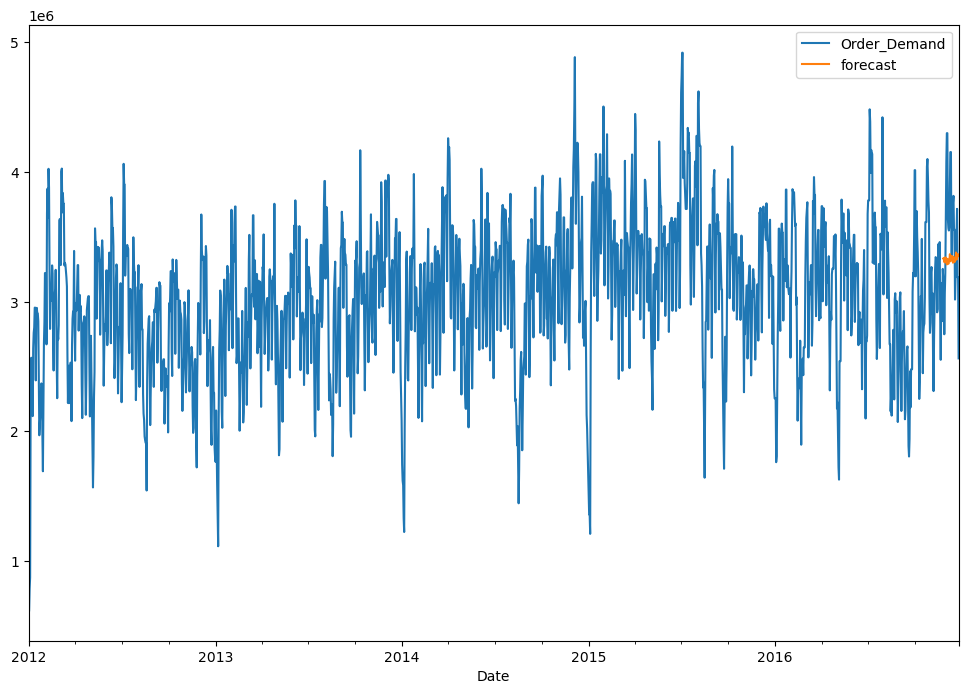

In [31]:
filterr_df['forecast']= results.predict(start=1790, end= 1821, dynamic=True)
filterr_df[['Order_Demand', 'forecast']].plot(figsize=(12,8))

## Try to group by month the data

In [21]:
filterr_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1821 entries, 2012-01-01 to 2016-12-25
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order_Demand  1821 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [22]:
df_monthly= filterr_df.resample('M').sum()

In [23]:
p=d=q=range(0,1)
pdq= list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima= ARIMA(df_monthly, order= param)
        model_arima_fit= model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue   


(0, 0, 0) 2285.9086267883004


In [24]:
model= ARIMA(df_monthly, order= (5,0,4))
model_fit= model.fit()
model_fit.summary()

c:\Users\John\anaconda3\envs\time_ser1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\John\anaconda3\envs\time_ser1\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\John\anaconda3\envs\time_ser1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Order_Demand   No. Observations:                   60
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -1032.471
Date:                Thu, 08 Jun 2023   AIC                           2086.943
Time:                        09:56:34   BIC                           2109.981
Sample:                    01-31-2012   HQIC                          2095.954
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.274e+07    2.2e-08   4.21e+15      0.000    9.27e+07    9.27e+07
ar.L1          0.1526      0.505      0.302      0.762      -0.837       1.142
ar.L2         -0.4557      0.406     -1.122      0.262      -1.252       0.340
ar.L3          0.3565      0.428      0.834      0.404      -0.481       1.194
ar.L4          0.4073      0.414      0.984      0.325      -0.404       1.219
ar.L5          0.2034      0.279      0.729      0.466      -0.344       0.750
ma.L1         -0.0361      0.534     -0.068      0.946      -1.082       1.010
ma.L2          0.5368      0.426      1.261      0.207      -0.298       1.371
ma.L3          0.2638      0.424      0.622      0.534      -0.567       1.095
ma.L4         -0.3938      0.355     -1.109      0.268      -1.090       0.302
sigma2      5.504e+13   2.11e-14   2.61e+27      0.000     5.5e+13     5.5e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.99   Prob(JB):                         0.67
Heteroskedasticity (H):               1.46   Skew:                            -0.25
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+43. Standard errors may be unstable.
"""

<Axes: xlabel='Date'>

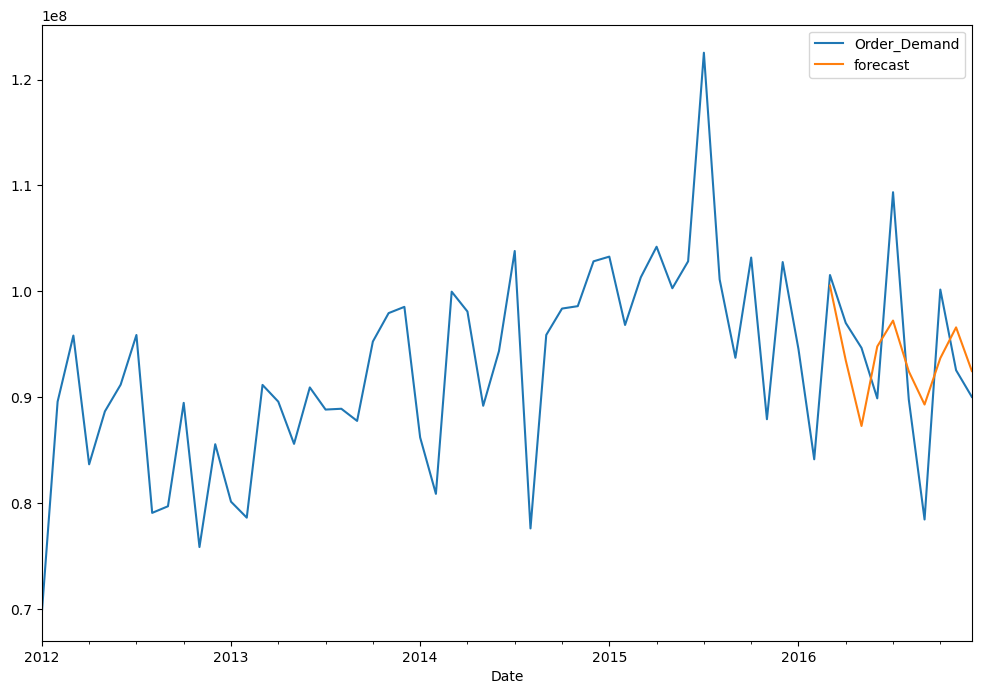

In [25]:
df_monthly['forecast']= model_fit.predict(start=50, end= 60, dynamic=True)
df_monthly[['Order_Demand', 'forecast']].plot(figsize=(12,8))

In [ ]:
df_monthly.tail(10)

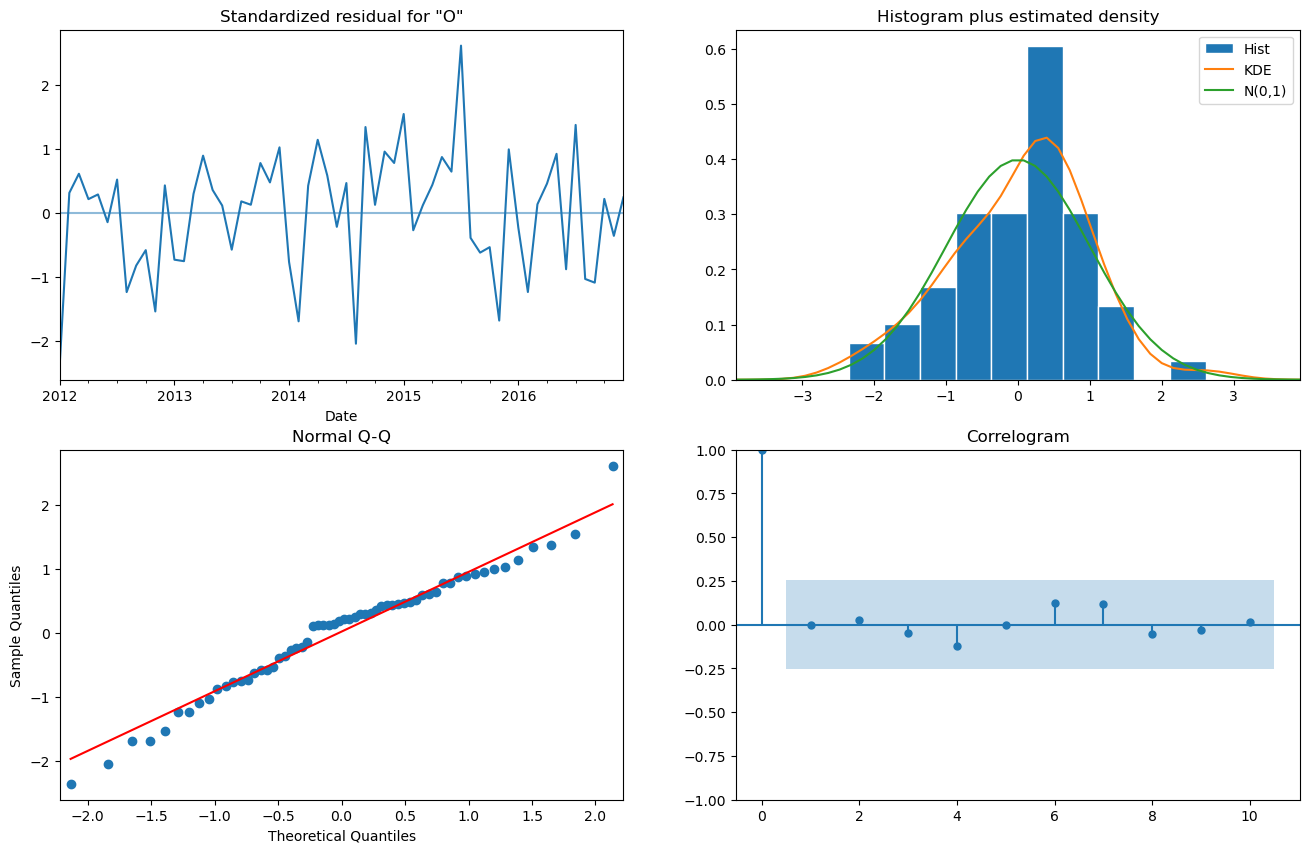

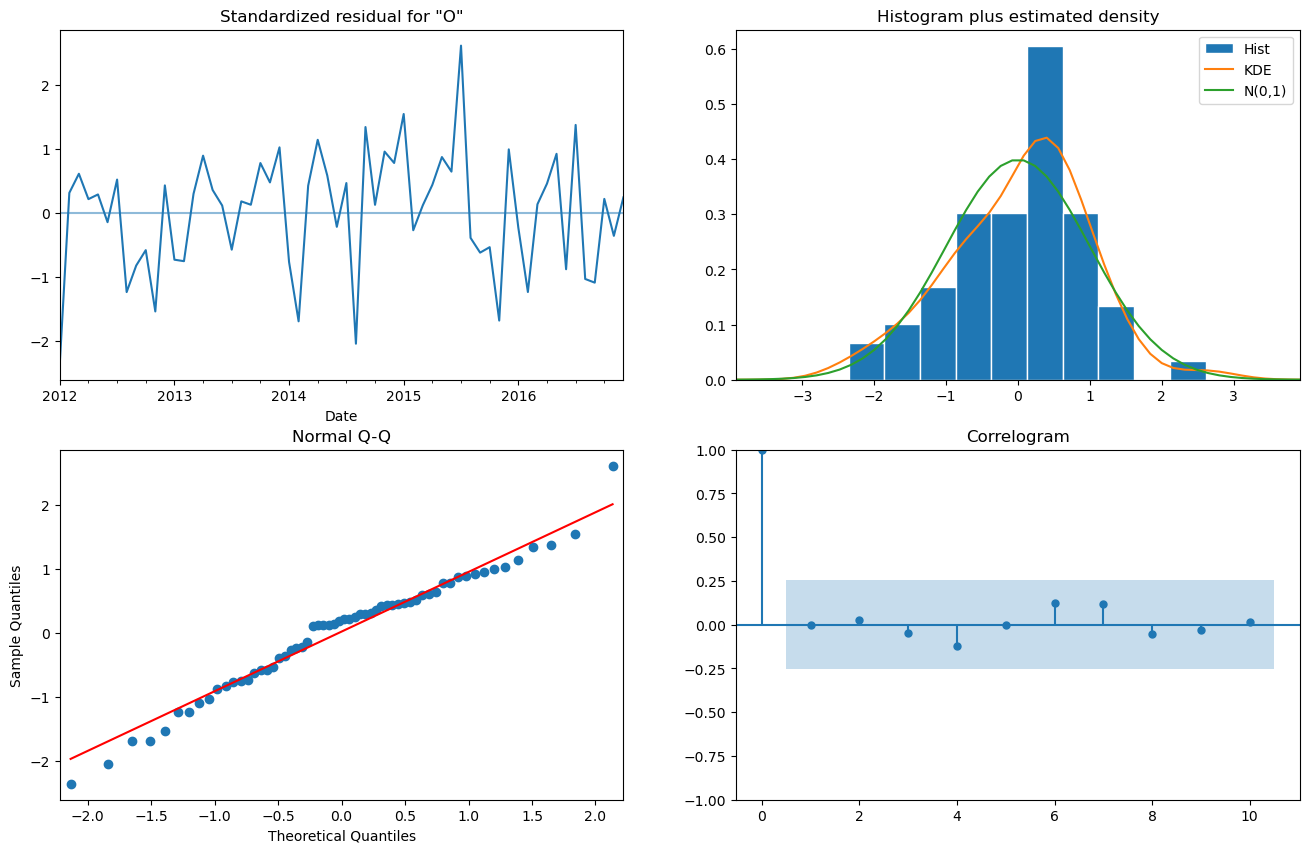

In [26]:
model_fit.plot_diagnostics(figsize=(16,10))

# Now use SARIMAX for monthly data

In [23]:
p=d=q=range(0,2)
pdq= list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
mikro = 100000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df_monthly,order=param, seasonal_order=param_seasonal,
            enforce_stationarity=False,enforce_invertibility=False) #i don't know if i need them
            results = mod.fit()
            if mikro > results.aic:
                mikro = results.aic
                mikro_str = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
        except:
            continue

In [26]:
mod = SARIMAX(df_monthly,order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
            enforce_stationarity=False,enforce_invertibility=False) #i don't know if i need them
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -588.277
Date:                             Thu, 08 Jun 2023   AIC                           1184.554
Time:                                     10:24:48   BIC                           1190.660
Sample:                                 01-31-2012   HQIC                          1186.636
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2442      0.368     -0.664      0.507      -0.965       0.477
ma.L1         -0.3906      0.259     -1.510      0.131      -0.898       0.116
ar.S.L12      -0.4299      0.188     -2.284      0.022      -0.799      -0.061
sigma2      7.735e+13        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.47   Prob(JB):                         0.54
Heteroskedasticity (H):               0.81   Skew:                            -0.43
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.39e+45. Standard errors may be unstable.
"""

<Axes: xlabel='Date'>

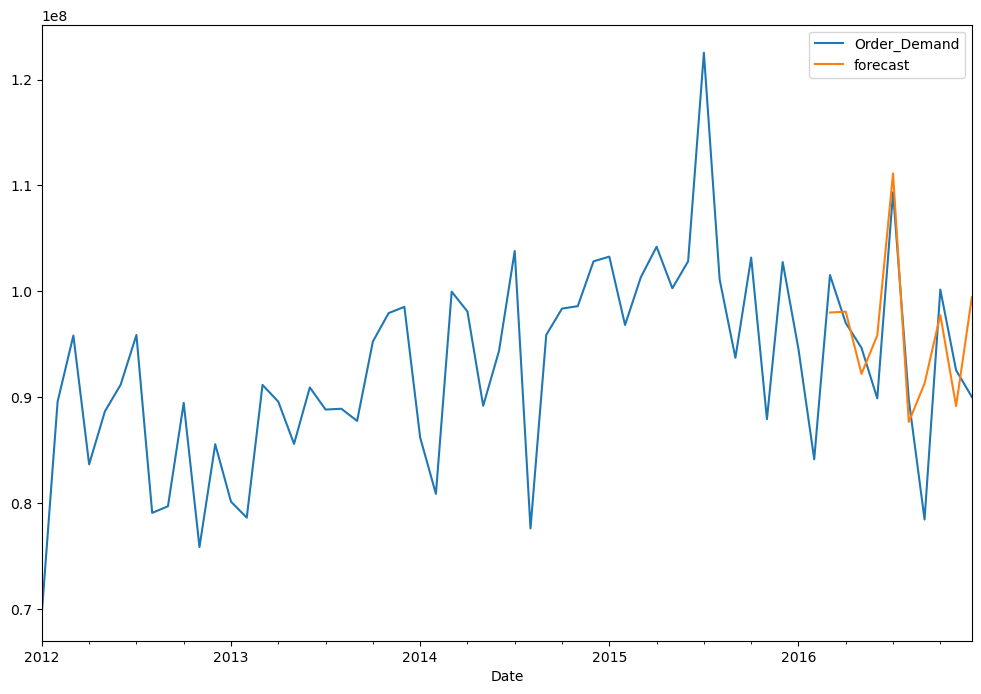

In [28]:
df_monthly['forecast']= results.predict(start=50, end= 60, dynamic=True)
df_monthly[['Order_Demand', 'forecast']].plot(figsize=(12,8))